<a href="https://colab.research.google.com/github/zahran1234/machine-learning-/blob/main/Sentiment_Analysis_features_extraction_from_word2vec150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
from scipy import stats
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score ,classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from gensim.models import Word2Vec
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.stem import ARLSTem
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
df= pd.read_excel('/content/original_dataset.xlsx')

In [56]:
df=pd.DataFrame(df)

In [58]:
df.head()

,Unnamed: 0,review_description,rating,company
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,1,ابلكيشن زباله بجد,-1,alahli_bank
2,2,سيئ التطبيق لايعمل,-1,alahli_bank
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank


In [59]:
print(df.shape)
df=df.dropna()
df=df.drop_duplicates()
print(df.shape)

(67127, 4)
(67125, 4)


# **data visualization**

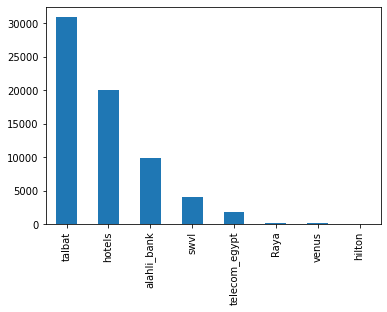

In [60]:
df.company.value_counts().plot(kind='bar')

In [61]:
fig = px.sunburst(df, path=['rating'],title= ' rating')
fig.update_traces(textinfo='label + percent parent')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



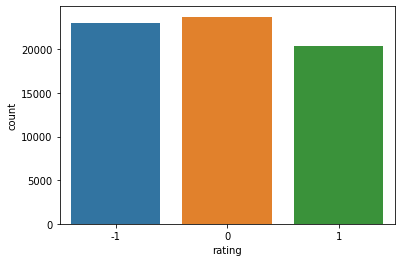

In [62]:
sns.countplot(df.rating)

In [63]:
fig = px.sunburst(df, path=['company', 'rating'],title= 'Relation between company and rating')
fig.update_traces(textinfo='label + percent parent')

# **data cleaning**

In [64]:
def del_digits_and_pun(value,pun):
    new_value= re.sub('[1-9]','',value)
    for i in pun:
        new_value=new_value.replace(i,' ')
    return new_value

In [65]:
def tokens_review(x,stop_words):
    x=str(x)
    words=word_tokenize(x)
    new_words=[]
    for i in words:
        text = re.sub(r'[^ء-ي ]',' ',i)
        
        if text not in stop_words:
            new_words.append(text)
    return new_words

delete english punctuations and arabic punctuations from our reviews

In [66]:
arabic_punctuations = """
`÷×؛،.<>_()*&^%][ـ،/:؟.,'{}~¦+|!”…“–#.ـ
"""

english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
punctuations_list
list_pun=[i for i in punctuations_list]


df.review_description=df.review_description.apply(del_digits_and_pun,args=[list_pun])



# ** staming  reviwe**

In [67]:
def preprossing (review):
  words=word_tokenize(review)
  new_words=[]
  stop_words=stopwords.words('arabic')
  stop_words.remove('لا')
  stop_words.remove('لكن')
  stop_words.remove('ولكن')
  stop_words.remove('واو')
  stop_words.remove('أطعم')
  stop_words.remove('أف')
  stop_words.append('طلبات')
  stop_words.append('شركه')
  stop_words.append('برنامج')
  stop_words.append('تطبيق')
  for i in words:
    stemmer = ARLSTem()
    word = stemmer.stem(i)
    if i in stop_words:
      continue 
    new_words.append(word)

  return new_words




In [68]:
import nltk

df.steming_list=df.review_description.apply(preprossing)

<ipython-input-68-7b2250f778a7>:3: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



# **features extraction  word2vec**

In [69]:
from gensim.models import Word2Vec
sents=[]
dim_num=100
for i in df.steming_list:
  sents.append(i)
model=Word2Vec(sentences=sents, window=5, min_count=1, workers=4,size=dim_num)

In [70]:
X=np.zeros((dim_num,), dtype=float)

for i in  df.steming_list:
  counter=0
  sum=np.zeros((100,), dtype=float)
  for x in i :
    sum+=model.wv[x]
    counter+=1
  if counter==0 :
    X=np.vstack((X,sum))
  else:
    X=np.vstack((X,sum/counter))
X= np.delete(X, (0), axis=0)
y=df.rating 
X.shape

  

(67125, 100)

In [71]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

In [90]:
def get_accuracy_NN(name, trained_model , x_train, y_train, x_test, y_test,y_train_enc,y_test_enc):
  loss,acc=model.evaluate(x_test,y_test_enc)
  print("test loss :", loss)
  print('test accuracy:',acc*100)
  print("____________________________")
  loss,acc=model.evaluate(x_train,y_train_enc)
  print("trainig loss :", loss)
  print('trainig accuracy:',acc*100)
  print("____________________________")

  pred=model.predict(x_test)
  pred_list=[]
  for i in pred:
    pred_list.append(np.argmax(i))
  cf1 = confusion_matrix(y_test,pred_list)
  sns.heatmap(cf1,annot=True,fmt = '.0f')
  plt.xlabel('prediction')
  plt.ylabel('Actual')
  plt.title(name+ ' Confusion Matrix')
  plt.show()
  print("true")
  print(classification_report(y_test,pred_list  ))
  


# ** LinearSVC model** 

In [73]:
from sklearn.model_selection import train_test_split

def encod(x):
  if x==-1:
    return 0
  if x== 0:
    return 1
  return 2
y=df.rating
y=y.apply(encod)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.10,shuffle=True)
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc=tf.keras.utils.to_categorical(y_test)


In [74]:

from sklearn.svm import LinearSVC
trained_clf_svc = LinearSVC().fit(x_train, y_train)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Testing accuracy   : 81.81141069566513 %
MSE [TEST]          : 0.3816475495307612
Training accuracy  : 81.5715420777329 %
MSE [TRAIN]         : 0.37656425875653843
precision :  0.8181141069566513
recall    :  0.8181141069566513
f1_score  :  0.8181141069566513


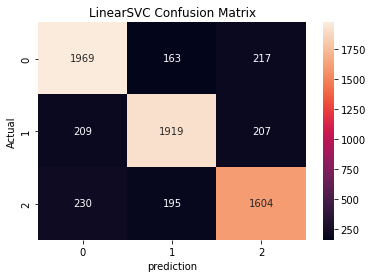

              precision    recall  f1-score   support

           0       0.82      0.83      0.83     20686
           1       0.84      0.81      0.83     21416
           2       0.78      0.80      0.79     18310

    accuracy                           0.82     60412
   macro avg       0.81      0.82      0.81     60412
weighted avg       0.82      0.82      0.82     60412

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2349
           1       0.84      0.82      0.83      2335
           2       0.79      0.79      0.79      2029

    accuracy                           0.82      6713
   macro avg       0.82      0.82      0.82      6713
weighted avg       0.82      0.82      0.82      6713



In [75]:
get_accuracy('LinearSVC',trained_clf_svc,x_train, y_train, x_test, y_test)

# **apply decision tree model**

Testing accuracy   : 77.38715924325935 %
MSE [TEST]          : 0.5134813049307314
Training accuracy  : 78.07720320466133 %
MSE [TRAIN]         : 0.48237105210885256
precision :  0.7738715924325935
recall    :  0.7738715924325935
f1_score  :  0.7738715924325935


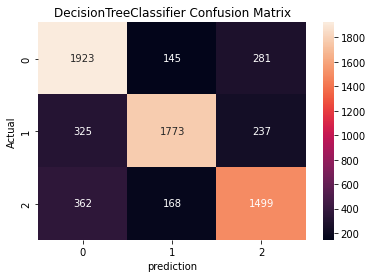

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     20686
           1       0.85      0.76      0.80     21416
           2       0.74      0.77      0.75     18310

    accuracy                           0.78     60412
   macro avg       0.78      0.78      0.78     60412
weighted avg       0.78      0.78      0.78     60412

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      2349
           1       0.85      0.76      0.80      2335
           2       0.74      0.74      0.74      2029

    accuracy                           0.77      6713
   macro avg       0.78      0.77      0.77      6713
weighted avg       0.78      0.77      0.77      6713



In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split= 2).fit(x_train,y_train)
get_accuracy('DecisionTreeClassifier',clf,x_train, y_train, x_test, y_test)


# **random forest model**

Testing accuracy   : 82.70519886786832 %
MSE [TEST]          : 0.42186801727990464
Training accuracy  : 84.6719194861948 %
MSE [TRAIN]         : 0.35062570350261535
precision :  0.8270519886786831
recall    :  0.8270519886786831
f1_score  :  0.8270519886786831


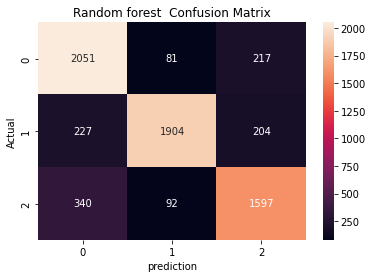

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     20686
           1       0.93      0.81      0.87     21416
           2       0.81      0.84      0.82     18310

    accuracy                           0.85     60412
   macro avg       0.85      0.85      0.85     60412
weighted avg       0.85      0.85      0.85     60412

              precision    recall  f1-score   support

           0       0.78      0.87      0.83      2349
           1       0.92      0.82      0.86      2335
           2       0.79      0.79      0.79      2029

    accuracy                           0.83      6713
   macro avg       0.83      0.83      0.83      6713
weighted avg       0.83      0.83      0.83      6713



In [77]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_depth=9,min_samples_leaf=5,min_samples_split=3).fit(x_train,y_train)
get_accuracy('Random forest ',model,x_train, y_train, x_test, y_test)


# **model 1 neural network**

In [78]:
NN_models=[]

In [113]:

model=Sequential()
model.add(Dense( 64 ,input_shape=(100,),activation='relu' ))
model.add(Dense(32, activation='relu',kernel_regularizer='l1'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                6464      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 3)                 51        
                                                                 
Total params: 9,123
Trainable params: 9,123
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(x_train,y_train_enc,batch_size=256 ,epochs=150)


Epoch 1/150
236/236 [==============================] - 1s 4ms/step - loss: 0.3787 - accuracy: 0.8597
Epoch 2/150
236/236 [==============================] - 1s 4ms/step - loss: 0.3773 - accuracy: 0.8601
Epoch 3/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3783 - accuracy: 0.8607
Epoch 4/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3795 - accuracy: 0.8588
Epoch 5/150
236/236 [==============================] - 0s 2ms/step - loss: 0.3780 - accuracy: 0.8601
Epoch 6/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3775 - accuracy: 0.8593
Epoch 7/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3767 - accuracy: 0.8607
Epoch 8/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3756 - accuracy: 0.8618
Epoch 9/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3762 - accuracy: 0.8608
Epoch 10/150
236/236 [==============================] - 1s 2ms/step - loss: 0.3760 - accura

210/210 [==============================] - 0s 1ms/step - loss: 0.4132 - accuracy: 0.8521
test loss : 0.413232684135437
test accuracy: 85.20780801773071
____________________________
1888/1888 [==============================] - 2s 1ms/step - loss: 0.3480 - accuracy: 0.8725
trainig loss : 0.3480154871940613
trainig accuracy: 87.24591135978699
____________________________
210/210 [==============================] - 0s 873us/step


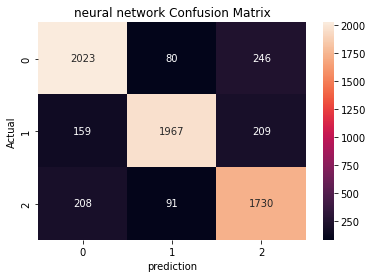

true
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2349
           1       0.92      0.84      0.88      2335
           2       0.79      0.85      0.82      2029

    accuracy                           0.85      6713
   macro avg       0.85      0.85      0.85      6713
weighted avg       0.86      0.85      0.85      6713



In [112]:
get_accuracy_NN("neural network",model,x_train,y_train,x_test,y_test,y_train_enc,y_test_enc)

# ***model 2 neural ntework***

In [92]:

model=Sequential()
model.add(Dense( 120,input_shape=(100,),activation='relu' ))

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])



Epoch 1/50
236/236 [==============================] - 1s 3ms/step - loss: 0.5499 - accuracy: 0.7983
Epoch 2/50
236/236 [==============================] - 1s 3ms/step - loss: 0.4512 - accuracy: 0.8327
Epoch 3/50
236/236 [==============================] - 1s 3ms/step - loss: 0.4341 - accuracy: 0.8381
Epoch 4/50
236/236 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.8414
Epoch 5/50
236/236 [==============================] - 1s 5ms/step - loss: 0.4153 - accuracy: 0.8433
Epoch 6/50
236/236 [==============================] - 1s 4ms/step - loss: 0.4068 - accuracy: 0.8478
Epoch 7/50
236/236 [==============================] - 1s 3ms/step - loss: 0.4013 - accuracy: 0.8483
Epoch 8/50
236/236 [==============================] - 1s 3ms/step - loss: 0.4004 - accuracy: 0.8486
Epoch 9/50
236/236 [==============================] - 1s 3ms/step - loss: 0.3959 - accuracy: 0.8501
Epoch 10/50
236/236 [==============================] - 1s 3ms/step - loss: 0.3926 - accuracy: 0.8516

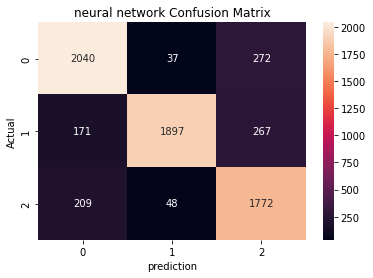

true
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2349
           1       0.96      0.81      0.88      2335
           2       0.77      0.87      0.82      2029

    accuracy                           0.85      6713
   macro avg       0.86      0.85      0.85      6713
weighted avg       0.86      0.85      0.85      6713



In [93]:
model.fit(x_train,y_train_enc,batch_size=256 ,epochs=50)
get_accuracy_NN("neural network",model,x_train,y_train,x_test,y_test,y_train_enc,y_test_enc)

CNN

In [94]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten
# Instantiate your model as usual
model = Sequential()
model.add(Conv2D(
                 filters=64,  
                 kernel_size=2,              
                 input_shape=(10,10,1),     
                 activation='relu')
)

model.add(Conv2D(8, kernel_size=3, activation='relu'))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(16, activation='relu'))
# End this multiclass model with 3 outputs and softmax
model.add(Dense(3, activation='softmax'))

model.summary ()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 64)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           4616      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                25152     
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dense_20 (Dense)            (None, 3)                 51        
                                                                 
Total params: 31,179
Trainable params: 31,179
Non-trai

In [95]:
model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
model.fit(x_train.reshape(-1,10,10,1),y_train_enc,batch_size=256 ,epochs=70)

Epoch 1/70
236/236 [==============================] - 11s 47ms/step - loss: 0.5648 - accuracy: 0.7896
Epoch 2/70
236/236 [==============================] - 7s 30ms/step - loss: 0.4611 - accuracy: 0.8279
Epoch 3/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4399 - accuracy: 0.8338
Epoch 4/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4316 - accuracy: 0.8360
Epoch 5/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4244 - accuracy: 0.8390
Epoch 6/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4199 - accuracy: 0.8408
Epoch 7/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4138 - accuracy: 0.8428
Epoch 8/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4112 - accuracy: 0.8446
Epoch 9/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4058 - accuracy: 0.8455
Epoch 10/70
236/236 [==============================] - 7s 31ms/step - loss: 0.4046 - accur

In [98]:

pred=model.predict(x_test.reshape(-1,10,10,1))
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
from sklearn.metrics import accuracy_score
print("test accuracy : ", accuracy_score(y_test,pred_list)*100)
print("_______________________")
print(classification_report(y_test,pred_list  ))
print("confusion  matrix")
print(confusion_matrix(pred_list, y_test))

210/210 [==============================] - 1s 2ms/step
test accuracy :  84.86518695069269
_______________________
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2349
           1       0.92      0.83      0.87      2335
           2       0.80      0.84      0.82      2029

    accuracy                           0.85      6713
   macro avg       0.85      0.85      0.85      6713
weighted avg       0.85      0.85      0.85      6713

confusion  matrix
[[2059  186  239]
 [  77 1943   95]
 [ 213  206 1695]]
